<a href="https://colab.research.google.com/github/Offliners/writeup/blob/main/HW5/homework5-back.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 5 - Sequence-to-sequence**

If you have any questions, feel free to email us at: ntu-ml-2021spring-ta@googlegroups.com

### (4/14 Updates) 
1. Link to tutorial video [part 1](https://youtu.be/1pjS5_L5REI) [part 2](https://youtu.be/3XX9d0ymKgQ).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence Introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Download and import required packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/HW5/

Mounted at /content/drive


In [3]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 901kB 10.1MB/s 
     |████████████████████████████████| 1.2MB 25.9MB/s 
     |████████████████████████████████| 2.1MB 48.6MB/s 
     |████████████████████████████████| 163kB 45.8MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=0c6a8514226027f6cf2da09c9e7c6c90d9a022a59a5b3e6bb009bc7c0ed305be
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=7222df433dc36ed72961b4a2a00184496c04bb85092b961b8e92c3cabd181714
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built path

In [4]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 27719, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 27719 (delta 65), reused 104 (delta 56), pack-reused 27579
Receiving objects: 100% (27719/27719), 11.58 MiB | 29.21 MiB/s, done.
Resolving deltas: 100% (20884/20884), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... do

In [5]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [6]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset Information

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

# Dataset Download

## Install megatools (optional)

In [7]:
#!apt-get install megatools

## Download and extract

In [8]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

--2021-04-27 14:37:10--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yva8og.dm.files.1drv.com/y4m4dx-QOmy3PS1GnBFeHY7EU77cS_e53CeEG2rX9Lm5vHoXED1YMQhpfUXsl9axwjx7XZbNLDIY4gZ7C3n7sqXUIPdFuQvTefi0KEJIr4XA6JUjAZlG_8JfTJPFs-rMLzSY_VB6D9uvAzN3m8xtYTXQEnR8wkmGDgXm0-ChCfcL002YYfoBeMjOpXacWVaNMV5P1SH0pF5yGmqknK9kIGWTA/ted2020.tgz?download&psid=1 [following]
--2021-04-27 14:37:11--  https://yva8og.dm.files.1drv.com/y4m4dx-QOmy3PS1GnBFeHY7EU77cS_e53CeEG2rX9Lm5vHoXED1YMQhpfUXsl9axwjx7XZbNLDIY4gZ7C3n7sqXUIPdFuQvTefi0KEJIr4XA6JUjAZlG_8JfTJPFs-rMLzSY_VB6D9uvAzN3m8xtYTXQEnR8wkmGDgXm0-ChCfcL002YYfoBeMjOpXacWVaNMV5P1SH0pF5yGmqknK9kIGWTA/ted2020.tgz?download&psid=1
Resolving yva8og.dm.files.1drv.com (yva8og.dm.files.1drv.com).

## Language

In [9]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [10]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [11]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [12]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [13]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [14]:
 !cp -r ./DATA /content/drive/MyDrive/HW5/
 # !ln -s /content/drive/MyDrive/HW5/DATA/ ./DATA

In [15]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [16]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [17]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [18]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [19]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !


## Binarize the data with fairseq

In [20]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2021-04-27 14:42:13 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

# Configuration for Experiments

In [22]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "/content/drive/MyDrive/HW5/checkpoints/transformer-back",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=0,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    # resume = None,
    resume = "checkpoint_last.pt", # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [23]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environment

In [24]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-27 14:45:16 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-27 14:45:16 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 14.756 GB ; name = Tesla T4                                
2021-04-27 14:45:16 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [25]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-27 14:45:18 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-04-27 14:45:18 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [26]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-27 14:45:20 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-27 14:45:20 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-04-27 14:45:20 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-04-27 14:45:20 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2021-04-27 14:45:20 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-04-27 14:45:20 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-04-27 14:45:20 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [27]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2]),
 'target': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [28]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-27 14:45:24 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3525, 1062, 527, 2861, 2415, 1633, 1624, 2626, 210, 880]


{'id': tensor([3517]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,
            188,    4,   33,    4,   32,    1,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([13]),
  'src_tokens': tensor([[   1,    1,    1,    4, 1259, 2926,  157, 3552, 1591,  137,  162, 1173,
            434,    4,   33,    2]])},
 'nsentences': 1,
 'ntokens': 17,
 'target': tensor([[   4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,  188,
             4,   33,    4,   32,    2,    1,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [29]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [30]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [31]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [33]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [34]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [35]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [36]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [37]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [38]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-27 14:45:49 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [39]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [40]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Scheduling Visualized

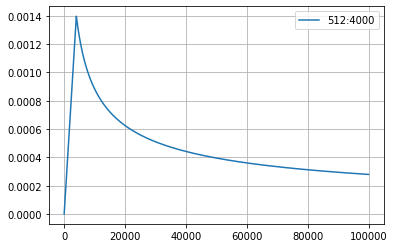

In [41]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
plt.grid()
None

# Training Procedure

## Training

In [42]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [43]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [44]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights

In [45]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [46]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [47]:
!nvidia-smi

Tue Apr 27 14:46:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |   1258MiB / 15109MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-27 14:46:03 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-27 14:46:03 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-27 14:46:03 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-27 14:46:03 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-27 14:46:03 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-27 14:46:03 | INFO | hw5.seq2seq | num. model params: 52,332,544 (num. trained: 52,332,544)
2021-04-27 14:46:03 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 2


In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-27 14:46:04 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-27 14:46:07 | INFO | hw5.seq2seq | loaded checkpoint /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint_last.pt: step=17436 loss=2.531278133392334 bleu=20.27085604106154


2021-04-27 14:56:23 | INFO | hw5.seq2seq | training loss: 2.2831
2021-04-27 14:56:23 | INFO | hw5.seq2seq | begin validation


2021-04-27 14:57:18 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 14:57:18 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 14:57:18 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 14:57:19 | INFO | hw5.seq2seq | example source: 好像大家對人物比較有反應 。
2021-04-27 14:57:19 | INFO | hw5.seq2seq | example hypothesis: it's as if people are more responsive to people .
2021-04-27 14:57:19 | INFO | hw5.seq2seq | example reference: somehow , to people , we're slightly better at responding to that sometimes .
2021-04-27 14:57:19 | INFO | hw5.seq2seq | validation loss:	2.5340
2021-04-27 14:57:19 | INFO | hw5.seq2seq | BLEU = 20.56 57.2/28.7/16.3/9.6 (BP = 0.913 ratio = 0.916 hyp_len = 70595 ref_len = 77050)
2021-04-27 14:57:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoin

2021-04-27 15:07:42 | INFO | hw5.seq2seq | training loss: 2.2510
2021-04-27 15:07:42 | INFO | hw5.seq2seq | begin validation


2021-04-27 15:08:37 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 15:08:37 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 15:08:37 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 15:08:38 | INFO | hw5.seq2seq | example source: 謝謝 。
2021-04-27 15:08:38 | INFO | hw5.seq2seq | example hypothesis: thank you .
2021-04-27 15:08:38 | INFO | hw5.seq2seq | example reference: thank you .
2021-04-27 15:08:38 | INFO | hw5.seq2seq | validation loss:	2.5398
2021-04-27 15:08:38 | INFO | hw5.seq2seq | BLEU = 20.43 56.9/28.3/16.2/9.5 (BP = 0.917 ratio = 0.920 hyp_len = 70914 ref_len = 77050)
2021-04-27 15:08:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint2.pt
2021-04-27 15:08:40 | INFO | hw5.seq2seq | end of epoch 2


2021-04-27 15:19:00 | INFO | hw5.seq2seq | training loss: 2.2227
2021-04-27 15:19:00 | INFO | hw5.seq2seq | begin validation


2021-04-27 15:19:55 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 15:19:55 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 15:19:55 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 15:19:56 | INFO | hw5.seq2seq | example source: 我們仍有許多要努力的地方 。
2021-04-27 15:19:56 | INFO | hw5.seq2seq | example hypothesis: we still have a lot of work to do .
2021-04-27 15:19:56 | INFO | hw5.seq2seq | example reference: we have some serious work still to do .
2021-04-27 15:19:56 | INFO | hw5.seq2seq | validation loss:	2.5374
2021-04-27 15:19:56 | INFO | hw5.seq2seq | BLEU = 20.33 57.1/28.6/16.2/9.5 (BP = 0.907 ratio = 0.911 hyp_len = 70185 ref_len = 77050)
2021-04-27 15:19:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint3.pt
2021-04-27 15:19:

2021-04-27 15:30:17 | INFO | hw5.seq2seq | training loss: 2.1971
2021-04-27 15:30:17 | INFO | hw5.seq2seq | begin validation


2021-04-27 15:31:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 15:31:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 15:31:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 15:31:13 | INFO | hw5.seq2seq | example source: 他叫丹尼班賽特 , 23年之後 , 就是這一年也是在丹尼結婚的一年我們第一次通過fda批准一種藥物可精確地修復 " 囊狀纖維化 " 的缺陷基於所有對分子的認識的基礎上 。
2021-04-27 15:31:13 | INFO | hw5.seq2seq | example hypothesis: his name is daniel bensett , and 23 years later , this year and the year we got married in denny , and for the first time , we approved the fda to precisely repair the cystic fibrosis based on all knowledge of molecules .
2021-04-27 15:31:13 | INFO | hw5.seq2seq | example reference: that's danny bessette , 23 years later , because this is the year , and it's also the year where danny got married , where we have , for th

2021-04-27 15:41:38 | INFO | hw5.seq2seq | training loss: 2.1737
2021-04-27 15:41:38 | INFO | hw5.seq2seq | begin validation


2021-04-27 15:42:33 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 15:42:33 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 15:42:33 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 15:42:34 | INFO | hw5.seq2seq | example source: 而我身為一名訓練有素的傳染流行病學家 ,
2021-04-27 15:42:34 | INFO | hw5.seq2seq | example hypothesis: and i'm a trained epidemiologist .
2021-04-27 15:42:34 | INFO | hw5.seq2seq | example reference: now , i'm an infectious disease epidemiologist by training .
2021-04-27 15:42:34 | INFO | hw5.seq2seq | validation loss:	2.5501
2021-04-27 15:42:34 | INFO | hw5.seq2seq | BLEU = 20.77 57.2/28.8/16.5/9.7 (BP = 0.916 ratio = 0.919 hyp_len = 70843 ref_len = 77050)
2021-04-27 15:42:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkp

2021-04-27 15:53:02 | INFO | hw5.seq2seq | training loss: 2.1515
2021-04-27 15:53:02 | INFO | hw5.seq2seq | begin validation


2021-04-27 15:53:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 15:53:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 15:53:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 15:53:59 | INFO | hw5.seq2seq | example source: 我是在開玩笑 。
2021-04-27 15:53:59 | INFO | hw5.seq2seq | example hypothesis: i'm kidding .
2021-04-27 15:53:59 | INFO | hw5.seq2seq | example reference: i'm kidding .
2021-04-27 15:53:59 | INFO | hw5.seq2seq | validation loss:	2.5590
2021-04-27 15:53:59 | INFO | hw5.seq2seq | BLEU = 20.57 56.9/28.5/16.2/9.4 (BP = 0.922 ratio = 0.925 hyp_len = 71289 ref_len = 77050)
2021-04-27 15:54:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint6.pt
2021-04-27 15:54:01 | INFO | hw5.seq2seq | end of epoch 6


2021-04-27 16:04:26 | INFO | hw5.seq2seq | training loss: 2.1313
2021-04-27 16:04:26 | INFO | hw5.seq2seq | begin validation


2021-04-27 16:05:23 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 16:05:23 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 16:05:23 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 16:05:25 | INFO | hw5.seq2seq | example source: 就在每棟建築物間
2021-04-27 16:05:25 | INFO | hw5.seq2seq | example hypothesis: it's in every building .
2021-04-27 16:05:25 | INFO | hw5.seq2seq | example reference: it's between buildings .
2021-04-27 16:05:25 | INFO | hw5.seq2seq | validation loss:	2.5631
2021-04-27 16:05:25 | INFO | hw5.seq2seq | BLEU = 20.49 56.2/28.0/15.9/9.2 (BP = 0.934 ratio = 0.937 hyp_len = 72158 ref_len = 77050)
2021-04-27 16:05:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint7.pt
2021-04-27 16:05:27 | INFO | hw5.seq2seq | end of

2021-04-27 16:15:52 | INFO | hw5.seq2seq | training loss: 2.1122
2021-04-27 16:15:52 | INFO | hw5.seq2seq | begin validation


2021-04-27 16:16:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 16:16:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 16:16:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 16:16:49 | INFO | hw5.seq2seq | example source: 城市每平方英里一天會有5到10噸的排放量
2021-04-27 16:16:49 | INFO | hw5.seq2seq | example hypothesis: cities are emissions of five to 10 metric tons a day .
2021-04-27 16:16:49 | INFO | hw5.seq2seq | example reference: that comes out at five to 10 tons daily per square mile in cities .
2021-04-27 16:16:49 | INFO | hw5.seq2seq | validation loss:	2.5734
2021-04-27 16:16:49 | INFO | hw5.seq2seq | BLEU = 20.48 56.7/28.4/16.0/9.4 (BP = 0.923 ratio = 0.926 hyp_len = 71360 ref_len = 77050)
2021-04-27 16:16:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoi

2021-04-27 16:27:18 | INFO | hw5.seq2seq | training loss: 2.0949
2021-04-27 16:27:18 | INFO | hw5.seq2seq | begin validation


2021-04-27 16:28:13 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 16:28:13 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 16:28:13 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 16:28:14 | INFO | hw5.seq2seq | example source: 他們盡其所能 。
2021-04-27 16:28:14 | INFO | hw5.seq2seq | example hypothesis: they do what they can .
2021-04-27 16:28:14 | INFO | hw5.seq2seq | example reference: they got to work on what they could do .
2021-04-27 16:28:14 | INFO | hw5.seq2seq | validation loss:	2.5802
2021-04-27 16:28:14 | INFO | hw5.seq2seq | BLEU = 20.45 57.1/28.6/16.2/9.5 (BP = 0.914 ratio = 0.917 hyp_len = 70664 ref_len = 77050)
2021-04-27 16:28:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint9.pt
2021-04-27 16:28:16 | INFO | hw5.s

2021-04-27 16:38:41 | INFO | hw5.seq2seq | training loss: 2.0776
2021-04-27 16:38:41 | INFO | hw5.seq2seq | begin validation


2021-04-27 16:39:36 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 16:39:36 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 16:39:36 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 16:39:37 | INFO | hw5.seq2seq | example source: 這是我們感官的所在 , 我們特別的感官視覺、說話能力、聽覺、嗅覺、味覺 。
2021-04-27 16:39:37 | INFO | hw5.seq2seq | example hypothesis: this is where we feel our senses , our special sensory vision , our speech abilities , our auditory , our senses , our senses .
2021-04-27 16:39:37 | INFO | hw5.seq2seq | example reference: it's where our senses are located , our special senses our vision , our speech , our hearing , our smell , our taste .
2021-04-27 16:39:37 | INFO | hw5.seq2seq | validation loss:	2.5908
2021-04-27 16:39:37 | INFO | hw5.seq2seq | BLEU = 20.35 57.5/28.8/16.4/9.5 (BP = 0.902 ratio = 

2021-04-27 16:50:05 | INFO | hw5.seq2seq | training loss: 2.0614
2021-04-27 16:50:05 | INFO | hw5.seq2seq | begin validation


2021-04-27 16:51:01 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 16:51:01 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 16:51:01 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 16:51:03 | INFO | hw5.seq2seq | example source: 覺得 「 很溫暖 」 的則是平常的2.9倍 ,
2021-04-27 16:51:03 | INFO | hw5.seq2seq | example hypothesis: " warm , " it's 2 . 9 times warm .
2021-04-27 16:51:03 | INFO | hw5.seq2seq | example reference: they're feeling " warm " at 2 . 9 times the normal level , and so on .
2021-04-27 16:51:03 | INFO | hw5.seq2seq | validation loss:	2.5930
2021-04-27 16:51:03 | INFO | hw5.seq2seq | BLEU = 20.45 56.4/27.9/15.8/9.2 (BP = 0.934 ratio = 0.936 hyp_len = 72121 ref_len = 77050)
2021-04-27 16:51:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transforme

2021-04-27 17:01:32 | INFO | hw5.seq2seq | training loss: 2.0472
2021-04-27 17:01:32 | INFO | hw5.seq2seq | begin validation


2021-04-27 17:02:29 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 17:02:29 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 17:02:29 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 17:02:30 | INFO | hw5.seq2seq | example source: 所以我認為好消息是雖然現今世界非常的複雜 , 但你所需做的卻非常簡單 。
2021-04-27 17:02:30 | INFO | hw5.seq2seq | example hypothesis: so i think the good news is that although the world is very complicated today , what you need to do is very simple .
2021-04-27 17:02:30 | INFO | hw5.seq2seq | example reference: so i think the good news is that even though the world is extremely complex , what you need to do is very simple .
2021-04-27 17:02:30 | INFO | hw5.seq2seq | validation loss:	2.6033
2021-04-27 17:02:30 | INFO | hw5.seq2seq | BLEU = 20.34 56.4/28.1/15.8/9.2 (BP = 0.929 ratio = 0.932 hyp_len = 

2021-04-27 17:12:59 | INFO | hw5.seq2seq | training loss: 2.0327
2021-04-27 17:12:59 | INFO | hw5.seq2seq | begin validation


2021-04-27 17:13:55 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 17:13:55 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 17:13:55 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 17:13:56 | INFO | hw5.seq2seq | example source: 另一條是離子尾 , 含帶電粒子 , 其方向遵循太陽系內磁場方向 。
2021-04-27 17:13:56 | INFO | hw5.seq2seq | example hypothesis: another is ion tail , which contains charge particles in the direction of magnetic fields in our solar system .
2021-04-27 17:13:56 | INFO | hw5.seq2seq | example reference: the other one is an ion tail , which is charged particles , and they follow the magnetic field in the solar system .
2021-04-27 17:13:56 | INFO | hw5.seq2seq | validation loss:	2.6069
2021-04-27 17:13:56 | INFO | hw5.seq2seq | BLEU = 20.43 56.7/28.2/15.9/9.3 (BP = 0.926 ratio = 0.929 hyp_len = 71562 

2021-04-27 17:24:25 | INFO | hw5.seq2seq | training loss: 2.0192
2021-04-27 17:24:25 | INFO | hw5.seq2seq | begin validation


2021-04-27 17:25:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 17:25:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 17:25:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 17:25:23 | INFO | hw5.seq2seq | example source: 如果鬆開手 , 我會學到更多 , 能以開放和好奇的心態前進 。
2021-04-27 17:25:23 | INFO | hw5.seq2seq | example hypothesis: and if i'm relaxed , i'm going to learn more about the advancement of openness and curiosity .
2021-04-27 17:25:23 | INFO | hw5.seq2seq | example reference: i learn more when i proceed and loosen my grip and proceed openly with curiosity and wonder .
2021-04-27 17:25:23 | INFO | hw5.seq2seq | validation loss:	2.6184
2021-04-27 17:25:23 | INFO | hw5.seq2seq | BLEU = 20.54 56.4/28.0/15.9/9.4 (BP = 0.932 ratio = 0.935 hyp_len = 72009 ref_len = 77050)
2021-04-27 17:25:25 | INF

2021-04-27 17:35:52 | INFO | hw5.seq2seq | training loss: 2.0067
2021-04-27 17:35:52 | INFO | hw5.seq2seq | begin validation


2021-04-27 17:36:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 17:36:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 17:36:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 17:36:49 | INFO | hw5.seq2seq | example source: 我們的虛擬實境公司vrse在去年拍了15部電影我們從中學到了一些東西
2021-04-27 17:36:49 | INFO | hw5.seq2seq | example hypothesis: our virtual reality company , vrse , made 15 films last year , and we've learned something from it .
2021-04-27 17:36:49 | INFO | hw5.seq2seq | example reference: we've made 15 films in the last year at our vr company , vrse , and we've learned a few things .
2021-04-27 17:36:49 | INFO | hw5.seq2seq | validation loss:	2.6250
2021-04-27 17:36:49 | INFO | hw5.seq2seq | BLEU = 20.24 56.6/28.1/15.9/9.2 (BP = 0.922 ratio = 0.925 hyp_len = 71258 ref_len = 77050)
2021-04-27 17

2021-04-27 17:47:20 | INFO | hw5.seq2seq | training loss: 1.9951
2021-04-27 17:47:20 | INFO | hw5.seq2seq | begin validation


2021-04-27 17:48:16 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 17:48:16 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 17:48:16 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 17:48:17 | INFO | hw5.seq2seq | example source: 因此 , 我就與德國慈善社發起了一個為期三年的計畫 , 我們訓練了30名阿富汗男女 , 我們在喀布爾創建了15個諮詢中心 。
2021-04-27 17:48:17 | INFO | hw5.seq2seq | example hypothesis: and so i launched a threeyear plan with the german philanthropic societies that we trained 30 afghan women and we created 15 counseling centers in kabul .
2021-04-27 17:48:17 | INFO | hw5.seq2seq | example reference: so , i was able to launch a threeyear project with caritas germany , and we trained 30 afghan women and men , and we opened 15 counseling centers in kabul .
2021-04-27 17:48:17 | INFO | hw5.seq2seq | validation loss:	2.6349
2021-

2021-04-27 17:58:50 | INFO | hw5.seq2seq | training loss: 1.9829
2021-04-27 17:58:50 | INFO | hw5.seq2seq | begin validation


2021-04-27 17:59:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 17:59:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 17:59:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 17:59:48 | INFO | hw5.seq2seq | example source: 我說過他們是很有冒險精神的人
2021-04-27 17:59:48 | INFO | hw5.seq2seq | example hypothesis: i said they were very adventurous people .
2021-04-27 17:59:48 | INFO | hw5.seq2seq | example reference: as i said , they were adventurous people .
2021-04-27 17:59:48 | INFO | hw5.seq2seq | validation loss:	2.6375
2021-04-27 17:59:48 | INFO | hw5.seq2seq | BLEU = 20.41 56.2/27.7/15.8/9.3 (BP = 0.933 ratio = 0.935 hyp_len = 72039 ref_len = 77050)
2021-04-27 17:59:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint17.pt
2021-0

2021-04-27 18:10:20 | INFO | hw5.seq2seq | training loss: 1.9717
2021-04-27 18:10:20 | INFO | hw5.seq2seq | begin validation


2021-04-27 18:11:15 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 18:11:15 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 18:11:15 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 18:11:16 | INFO | hw5.seq2seq | example source: 這個主意其實很簡單
2021-04-27 18:11:16 | INFO | hw5.seq2seq | example hypothesis: the idea is actually pretty simple .
2021-04-27 18:11:16 | INFO | hw5.seq2seq | example reference: the idea is very , very simple .
2021-04-27 18:11:16 | INFO | hw5.seq2seq | validation loss:	2.6471
2021-04-27 18:11:16 | INFO | hw5.seq2seq | BLEU = 20.17 56.9/28.2/15.9/9.3 (BP = 0.914 ratio = 0.918 hyp_len = 70716 ref_len = 77050)
2021-04-27 18:11:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint18.pt
2021-04-27 18:11:20 | INFO 

2021-04-27 18:21:47 | INFO | hw5.seq2seq | training loss: 1.9617
2021-04-27 18:21:47 | INFO | hw5.seq2seq | begin validation


2021-04-27 18:22:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 18:22:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 18:22:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 18:22:44 | INFO | hw5.seq2seq | example source: 事實上一個在資訊安全業界的朋友幾天前告訴我說這世上只有兩種公司已被駭和還沒被駭
2021-04-27 18:22:44 | INFO | hw5.seq2seq | example hypothesis: as a matter of fact , a friend in the i . s . industry told me that only two companies in the world have been hacked and haven't yet been hacked .
2021-04-27 18:22:44 | INFO | hw5.seq2seq | example reference: in fact , a friend of mine from the security industry told me the other day that there are two types of companies in the world: those that know they've been hacked , and those that don't .
2021-04-27 18:22:44 | INFO | hw5.seq2seq | validation loss:	2.6515
2021

2021-04-27 18:33:16 | INFO | hw5.seq2seq | training loss: 1.9512
2021-04-27 18:33:16 | INFO | hw5.seq2seq | begin validation


2021-04-27 18:34:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 18:34:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 18:34:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 18:34:13 | INFO | hw5.seq2seq | example source: 所以 , 下一次當隱私權受到侵害的人來找你時 , 不要責備他們 , 反之 , 我們應該這樣做:讓我們改變對數位隱私的窠臼觀點 , 以同情心、同理心來回應吧 。
2021-04-27 18:34:13 | INFO | hw5.seq2seq | example hypothesis: so the next time privacy victims come to you , don't blame them , instead we should be doing this: let's change our view of digital privacy with compassion and compassion and empathy .
2021-04-27 18:34:13 | INFO | hw5.seq2seq | example reference: so the next time a victim of a privacy violation comes up to you , instead of blaming them , let's do this instead: let's shift our ideas about digital privacy , and let's respond wi

2021-04-27 18:44:46 | INFO | hw5.seq2seq | training loss: 1.9423
2021-04-27 18:44:46 | INFO | hw5.seq2seq | begin validation


2021-04-27 18:45:41 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 18:45:41 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 18:45:41 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 18:45:43 | INFO | hw5.seq2seq | example source: 很多人 , 包括我的媽媽在內 , 都說我瘋了 。
2021-04-27 18:45:43 | INFO | hw5.seq2seq | example hypothesis: a lot of people , including my mother , said i was crazy .
2021-04-27 18:45:43 | INFO | hw5.seq2seq | example reference: many people , including my mother , said i was crazy .
2021-04-27 18:45:43 | INFO | hw5.seq2seq | validation loss:	2.6716
2021-04-27 18:45:43 | INFO | hw5.seq2seq | BLEU = 20.26 56.4/28.0/15.9/9.3 (BP = 0.921 ratio = 0.924 hyp_len = 71196 ref_len = 77050)
2021-04-27 18:45:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/t

2021-04-27 18:56:12 | INFO | hw5.seq2seq | training loss: 1.9328
2021-04-27 18:56:12 | INFO | hw5.seq2seq | begin validation


2021-04-27 18:57:07 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 18:57:07 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 18:57:07 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 18:57:09 | INFO | hw5.seq2seq | example source: 而應該將主要精力放在知識創造上 。
2021-04-27 18:57:09 | INFO | hw5.seq2seq | example hypothesis: it should be prioritized in knowledge to create .
2021-04-27 18:57:09 | INFO | hw5.seq2seq | example reference: they should be dedicated mainly to knowledge production .
2021-04-27 18:57:09 | INFO | hw5.seq2seq | validation loss:	2.6776
2021-04-27 18:57:09 | INFO | hw5.seq2seq | BLEU = 20.26 56.4/27.8/15.7/9.2 (BP = 0.928 ratio = 0.931 hyp_len = 71702 ref_len = 77050)
2021-04-27 18:57:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-ba

2021-04-27 19:07:39 | INFO | hw5.seq2seq | training loss: 1.9242
2021-04-27 19:07:39 | INFO | hw5.seq2seq | begin validation


2021-04-27 19:08:34 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 19:08:34 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 19:08:34 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 19:08:35 | INFO | hw5.seq2seq | example source: 我想這項科技的運用讓道格拉斯.諾斯感到驚訝的地方 , 應該就是區塊鏈技術真的辦到了 , 而讓區塊鏈維持安全且易確證的原因就是我們彼此的不信任 。
2021-04-27 19:08:35 | INFO | hw5.seq2seq | example hypothesis: and i think the surprising use of this technology to bring douglas nose to surprise is that blockchain technology is real , and it keeps the blockchain safe and valid to guarantee us for distrust .
2021-04-27 19:08:35 | INFO | hw5.seq2seq | example reference: i think what would probably floor douglass north about this use of technology is the fact that the very thing that makes it work , the very thing that keeps the blockchain secu

2021-04-27 19:19:03 | INFO | hw5.seq2seq | training loss: 1.9156
2021-04-27 19:19:03 | INFO | hw5.seq2seq | begin validation


2021-04-27 19:19:59 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 19:19:59 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 19:19:59 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 19:20:00 | INFO | hw5.seq2seq | example source: 在那種情況下 , 我們可能會在給法院的信中建議發給緩刑者條列重要訊息的講義 。
2021-04-27 19:20:00 | INFO | hw5.seq2seq | example hypothesis: in that situation , we might recommend sending out important messages to the probationer's list .
2021-04-27 19:20:00 | INFO | hw5.seq2seq | example reference: in that case , our letter to the court might suggest that that probationer get handouts of important information .
2021-04-27 19:20:00 | INFO | hw5.seq2seq | validation loss:	2.6910
2021-04-27 19:20:00 | INFO | hw5.seq2seq | BLEU = 19.98 56.1/27.6/15.5/8.9 (BP = 0.929 ratio = 0.931 hyp_len = 71746 ref_len = 

2021-04-27 19:30:28 | INFO | hw5.seq2seq | training loss: 1.9071
2021-04-27 19:30:28 | INFO | hw5.seq2seq | begin validation


2021-04-27 19:31:24 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 19:31:24 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 19:31:24 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 19:31:25 | INFO | hw5.seq2seq | example source: 因此我們就先開始了一個臉書網頁 , 然後一個宣言 , 然後以一個非常簡單的方式 , 從街道開始報導 。
2021-04-27 19:31:25 | INFO | hw5.seq2seq | example hypothesis: so we start with a facebook page , and then a statement , and then we do it in a very simple way , starting from the street .
2021-04-27 19:31:25 | INFO | hw5.seq2seq | example reference: so we launched a facebook page first , and then a manifesto , and started to cover the streets in a very simple way .
2021-04-27 19:31:25 | INFO | hw5.seq2seq | validation loss:	2.6980
2021-04-27 19:31:25 | INFO | hw5.seq2seq | BLEU = 20.03 56.4/27.8/15.6/9.1 (BP = 0.9

2021-04-27 19:41:53 | INFO | hw5.seq2seq | training loss: 1.8995
2021-04-27 19:41:53 | INFO | hw5.seq2seq | begin validation


2021-04-27 19:42:49 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 19:42:49 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 19:42:49 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 19:42:51 | INFO | hw5.seq2seq | example source: 你的戒指呢 ?
2021-04-27 19:42:51 | INFO | hw5.seq2seq | example hypothesis: what about your ring ?
2021-04-27 19:42:51 | INFO | hw5.seq2seq | example reference: do you have a ring as well ?
2021-04-27 19:42:51 | INFO | hw5.seq2seq | validation loss:	2.7017
2021-04-27 19:42:51 | INFO | hw5.seq2seq | BLEU = 20.12 56.1/27.6/15.5/9.0 (BP = 0.933 ratio = 0.935 hyp_len = 72056 ref_len = 77050)
2021-04-27 19:42:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/HW5/checkpoints/transformer-back/checkpoint26.pt
2021-04-27 19:42:53 | INFO | hw5.seq2seq | end 

2021-04-27 19:53:20 | INFO | hw5.seq2seq | training loss: 1.8918
2021-04-27 19:53:20 | INFO | hw5.seq2seq | begin validation


2021-04-27 19:54:16 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 19:54:16 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 19:54:16 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 19:54:17 | INFO | hw5.seq2seq | example source: 我們無意要搞笑 , 我們也不是打算...不 , 應該說我們本來只打算搞笑
2021-04-27 19:54:17 | INFO | hw5.seq2seq | example hypothesis: we're not meant to be funny , we're not going to go no , we're going to make fun of us .
2021-04-27 19:54:17 | INFO | hw5.seq2seq | example reference: we weren't trying to be funny , we weren't trying to be well , we were trying to be funny actually , that's not true .
2021-04-27 19:54:17 | INFO | hw5.seq2seq | validation loss:	2.7139
2021-04-27 19:54:17 | INFO | hw5.seq2seq | BLEU = 19.93 56.0/27.4/15.3/8.9 (BP = 0.930 ratio = 0.933 hyp_len = 71855 ref_len = 77050)
2

2021-04-27 20:04:44 | INFO | hw5.seq2seq | training loss: 1.8847
2021-04-27 20:04:44 | INFO | hw5.seq2seq | begin validation


2021-04-27 20:05:40 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-27 20:05:40 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-27 20:05:40 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-27 20:05:41 | INFO | hw5.seq2seq | example source: 你要做的 , 就是把你的問題和以前別人所遇到的問題做比對 , 再利用他們已經想出的辦法來解決 。
2021-04-27 20:05:41 | INFO | hw5.seq2seq | example hypothesis: and what you do is you compare your problems with the problems that other people have come up with , and then you address them with the ways that they already have .
2021-04-27 20:05:41 | INFO | hw5.seq2seq | example reference: because what you can do is take your problem , and turn it into a problem that someone else has solved , and use their solutions .
2021-04-27 20:05:41 | INFO | hw5.seq2seq | validation loss:	2.7162
2021-04-27 20:05:41 | INFO | hw5.s

# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

## Generate Prediction

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)

In [ ]:
# from google.colab import files
# files.download("prediction.txt")

In [ ]:
raise

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
# binpath = Path('./DATA/data-bin/synthetic')
# src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
# tgt_dict_file = src_dict_file
# monopref = ./DATA/rawdata/mono/mono.tok # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
# if binpath.exists():
#     print(binpath, "exists, will not overwrite!")
# else:
#     !python -m fairseq_cli.preprocess\
#         --source-lang 'zh'\
#         --target-lang 'en'\
#         --trainpref {monopref}\
#         --destdir {binpath}\
#         --srcdict {src_dict_file}\
#         --tgtdict {tgt_dict_file}\
#         --workers 2

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html